## Final Project Submission

* Student name: John C Dean
* Student pace: Part Time
* Scheduled project review date/time: 6/15/2020 5:00pm 
* Instructor name: Eli Thomas
* Blog post URL:


## Introduction

The housing market can be a bit of a gamble. There can be regular market fluctuations, crashes like we saw in 2009, and many other sources of unpredictability that we don't tend to think about immediately. For those interested in buying and selling houses today, this leads to a pretty normal question: "Is there anything we can use to reliably predict sale price of homes?"

In this notebook, we will explore data from the Kings County housing market in the hopes of developing a model that can reliably predict the sale price of homes in the are. We will begin by exploring and preprocessing the data to ensure a viable model, then we will construct and train a regression model, and test it to ensure that we are within an acceptable degree of error for our projections. Without further ado, let us begin!

## Libraries

In [49]:
import pandas as pd # library for data analysis
import numpy as np # advanced computation library
import matplotlib.pyplot as plt # library for plotting data
%matplotlib inline
import seaborn as sns # plotting library we will use for histograms
import math
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import LabelBinarizer
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn import metrics
import statsmodels.api as sm

from sklearn.feature_selection import RFE
from sklearn.preprocessing import MinMaxScaler

import warnings

## Import, EDA, and Preprocessing

In [50]:
df = pd.read_csv('kc_house_data.csv') #importing our raw data
df.head() #inspecting the structure of the data

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,NaN,0.0,...,7,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,0.0,0.0,...,7,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639
2,5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,0.0,0.0,...,6,770,0.0,1933,NaN,98028,47.7379,-122.233,2720,8062
3,2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,0.0,0.0,...,7,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000
4,1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,0.0,0.0,...,8,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503


In [51]:
df.info() #checking for data types and missing data

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
id               21597 non-null int64
date             21597 non-null object
price            21597 non-null float64
bedrooms         21597 non-null int64
bathrooms        21597 non-null float64
sqft_living      21597 non-null int64
sqft_lot         21597 non-null int64
floors           21597 non-null float64
waterfront       19221 non-null float64
view             21534 non-null float64
condition        21597 non-null int64
grade            21597 non-null int64
sqft_above       21597 non-null int64
sqft_basement    21597 non-null object
yr_built         21597 non-null int64
yr_renovated     17755 non-null float64
zipcode          21597 non-null int64
lat              21597 non-null float64
long             21597 non-null float64
sqft_living15    21597 non-null int64
sqft_lot15       21597 non-null int64
dtypes: float64(8), int64(11), object(2)
memory usage: 3.5+ MB


In [52]:
# Checking for unusual values
df.sqft_basement.value_counts()[:10]

0.0       12826
?           454
600.0       217
500.0       209
700.0       208
800.0       201
400.0       184
1000.0      148
300.0       142
900.0       142
Name: sqft_basement, dtype: int64

In [53]:
print('Houses with no basement:', round( sum(df.sqft_basement == '0.0') / len(df), 2 ) * 100, '%' )

Houses with no basement: 59.0 %


In [54]:
df.sqft_basement = df.sqft_basement.map(lambda x: '0' if x == '?' else x)
df.sqft_basement = df.sqft_basement.astype('float')

In [55]:
df.date = pd.to_datetime(df['date']) #converting date column to datetime object for later processing
df['date']

0       2014-10-13
1       2014-12-09
2       2015-02-25
3       2014-12-09
4       2015-02-18
           ...    
21592   2014-05-21
21593   2015-02-23
21594   2014-06-23
21595   2015-01-16
21596   2014-10-15
Name: date, Length: 21597, dtype: datetime64[ns]

In [56]:
df.isnull().sum()

id                  0
date                0
price               0
bedrooms            0
bathrooms           0
sqft_living         0
sqft_lot            0
floors              0
waterfront       2376
view               63
condition           0
grade               0
sqft_above          0
sqft_basement       0
yr_built            0
yr_renovated     3842
zipcode             0
lat                 0
long                0
sqft_living15       0
sqft_lot15          0
dtype: int64

It appears that there is some missing data in the 'waterfront', 'view', and 'yr_renovated' columns. We should investigate these and decide how best to use them before moving on in our analysis. It may help us to further understand what the columns are describing. We have been given the following descriptions for our columns:

* **id** - unique identified for a house
* **date** - Date house was sold
* **price** - Price is prediction target
* **bedrooms** - Number of Bedrooms/House
* **bathrooms** - Number of bathrooms/bedrooms
* **sqft_livingsquare** - square footage of the home
* **sqft_lotsquare** -  square footage of the lot
* **floors** - Total floors (levels) in house
* **waterfront** - House which has a view to a waterfront
* **view** - Has been viewed
* **condition** - How good the condition is ( Overall )
* **grade** - overall grade given to the housing unit, based on King County grading system
* **sqft_above** - square footage of house apart from basement
* **sqft_basement** - square footage of the basement
* **yr_built** - Built Year
* **yr_renovated** - Year when house was renovated
* **zipcode** - zip
* **lat** - Latitude coordinate
* **long** - Longitude coordinate
* **sqft_living15** - The square footage of interior housing living space for the nearest 15 neighbors
* **sqft_lot15** - The square footage of the land lots of the nearest 15 neighbors

In [57]:
df.waterfront.value_counts()[:10]

0.0    19075
1.0      146
Name: waterfront, dtype: int64

It appears that the overwhelming majority of houses do not have a waterfront view. This also appears to be a categorical value. We feel safe that we can replace any missing values with '0'.

In [58]:
df.loc[df.waterfront.isna(), 'waterfront'] = 0
df.waterfront = df.waterfront.astype('int')
df.waterfront.isnull().sum()

0

In [59]:
df.view.value_counts()

0.0    19422
2.0      957
3.0      508
1.0      330
4.0      317
Name: view, dtype: int64

Similar to waterfront, it appears that the overwhelming number of homes have a '0' score, likely impying they have not been viewed. We will go ahead and replace null values with '0', based on the assumption that if a house has been viewed it would have a score. This will end up being another categorical variable.

In [60]:
df.loc[df.view.isna(), 'view'] = 0
df.view.isnull().sum()

0

In [61]:
df.yr_renovated.value_counts()

0.0       17011
2014.0       73
2003.0       31
2013.0       31
2007.0       30
          ...  
1946.0        1
1959.0        1
1971.0        1
1951.0        1
1954.0        1
Name: yr_renovated, Length: 70, dtype: int64

We will treat the yr_renovated column in the same way as our other missing variables. In all cases, finding accurate data to replace missing values with would be extremely difficult and possibly imposssible.

In [62]:
df.loc[df.yr_renovated.isna(), 'yr_renovated'] = 0
df.yr_renovated.isnull().sum()

0

In [63]:
df.isnull().sum()

id               0
date             0
price            0
bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
floors           0
waterfront       0
view             0
condition        0
grade            0
sqft_above       0
sqft_basement    0
yr_built         0
yr_renovated     0
zipcode          0
lat              0
long             0
sqft_living15    0
sqft_lot15       0
dtype: int64

In [64]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
id               21597 non-null int64
date             21597 non-null datetime64[ns]
price            21597 non-null float64
bedrooms         21597 non-null int64
bathrooms        21597 non-null float64
sqft_living      21597 non-null int64
sqft_lot         21597 non-null int64
floors           21597 non-null float64
waterfront       21597 non-null int32
view             21597 non-null float64
condition        21597 non-null int64
grade            21597 non-null int64
sqft_above       21597 non-null int64
sqft_basement    21597 non-null float64
yr_built         21597 non-null int64
yr_renovated     21597 non-null float64
zipcode          21597 non-null int64
lat              21597 non-null float64
long             21597 non-null float64
sqft_living15    21597 non-null int64
sqft_lot15       21597 non-null int64
dtypes: datetime64[ns](1), float64(8), int32(1), int64(11)
memory us

In [65]:
df.drop('id', axis=1, inplace=True)

Rather than seeing the year the house was built, it is more intuitive to see the age of the house at the time of the sale. We will change the yr_built column to age.

In [66]:
df['age'] = df.date.dt.year - df.yr_built 
df.drop('yr_built',axis=1,inplace=True)

Awesome! We have filled in all of our missing data, which will allow us to create accurate models for predicting the price of our houses.

For one last check before we begin exploring our data, let's check to see if we can reasonably remove any columns from our data without sacrificing accuracy in our model. We will do this by checking for strong correlations between variables.

In [67]:
# compute the pair wise correlation for all columns  
correlation_matrix = df.corr().round(2)

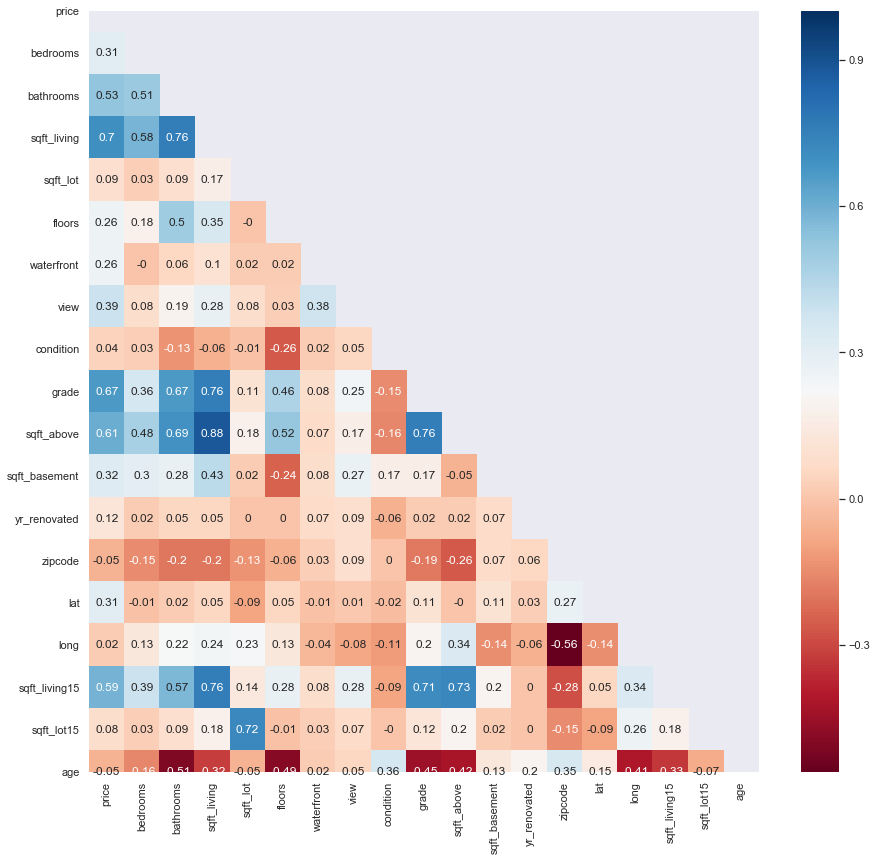

In [68]:
# set the size of the figure
sns.set(rc={'figure.figsize':(15,14)})
mask = np.zeros_like(correlation_matrix,dtype=np.bool)

# Create a msk to draw only lower diagonal corr map
mask[np.triu_indices_from(mask)] = True
# use the heatmap function from seaborn to plot the correlation matrix
# annot = True to print the values inside the square
sns.heatmap(data=correlation_matrix, cmap='RdBu', annot=True, mask=mask)

As you can see, sqft_above and sqft_living have an 88% correlation. We can safely drop one of these. Because of potential comparisons between sqft_living and sqft_living15, we will keep the sqft_living column.

In [69]:
# Removing sqft_above from our dataset
df.drop('sqft_above', axis=1, inplace=True)

In [83]:
df.drop('date', axis=1,inplace=True)

Let's see what happens when we map house price against map coordinates.

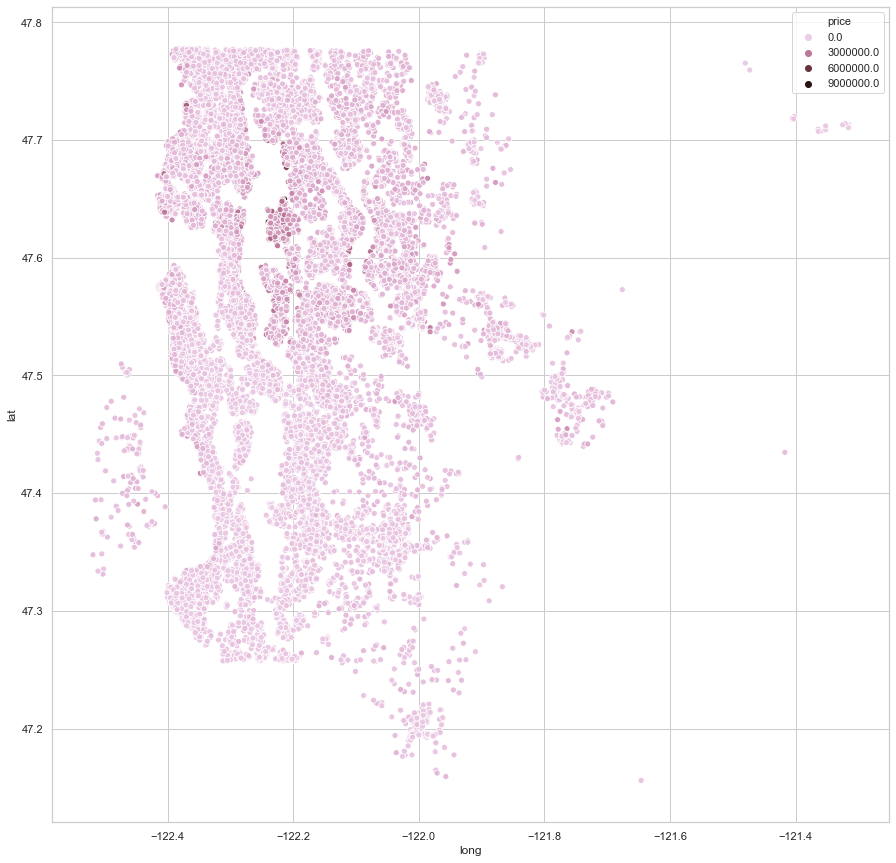

In [70]:
plt.figure(figsize=[15,15])
sns.set_style('whitegrid')
sns.scatterplot(x='long', y='lat', data=df, hue='price', palette="ch:1,-.2,dark=.1")
plt.show()

As we can see here, it does appear that location has some influence on the price. This may be due to access to waterfront properties, or it could be due to other factors. As we evaluate our model we will see if any of these factors seem irrelevant.

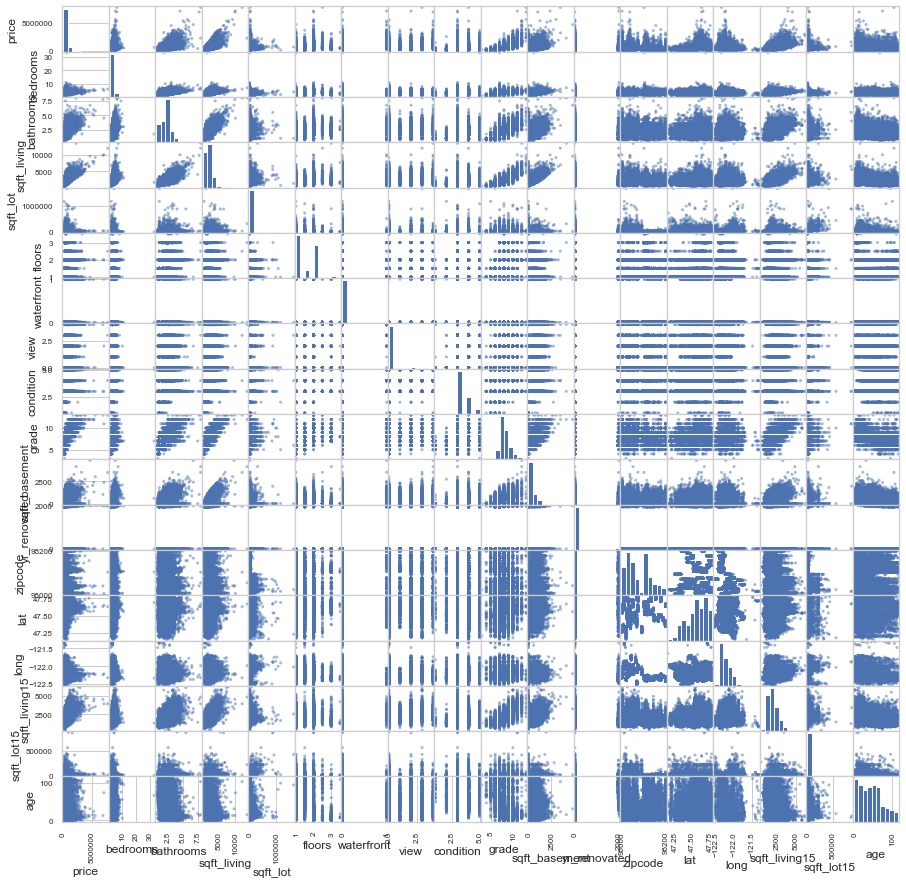

In [71]:
pd.plotting.scatter_matrix(df, figsize  = [15, 15]);
plt.show()

In [72]:
df.corr()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_basement,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,age
price,1.000000,0.308787,0.525906,0.701917,0.089876,0.256804,0.264306,0.393497,0.036056,0.667951,0.321108,0.117855,-0.053402,0.306692,0.022036,0.585241,0.082845,-0.053890
bedrooms,0.308787,1.000000,0.514508,0.578212,0.032471,0.177944,-0.002127,0.078354,0.026496,0.356563,0.297229,0.017900,-0.154092,-0.009951,0.132054,0.393406,0.030690,-0.155817
bathrooms,0.525906,0.514508,1.000000,0.755758,0.088373,0.502582,0.063629,0.186016,-0.126479,0.665838,0.278485,0.047177,-0.204786,0.024280,0.224903,0.569884,0.088303,-0.507561
sqft_living,0.701917,0.578212,0.755758,1.000000,0.173453,0.353953,0.104637,0.281715,-0.059445,0.762779,0.428660,0.051060,-0.199802,0.052155,0.241214,0.756402,0.184342,-0.318592
sqft_lot,0.089876,0.032471,0.088373,0.173453,1.000000,-0.004814,0.021459,0.075054,-0.008830,0.114731,0.015031,0.004979,-0.129586,-0.085514,0.230227,0.144763,0.718204,-0.052853
floors,0.256804,0.177944,0.502582,0.353953,-0.004814,1.000000,0.020797,0.028414,-0.264075,0.458794,-0.241866,0.003793,-0.059541,0.049239,0.125943,0.280102,-0.010722,-0.489514
waterfront,0.264306,-0.002127,0.063629,0.104637,0.021459,0.020797,1.000000,0.380543,0.016648,0.082818,0.083050,0.073939,0.028923,-0.012157,-0.037628,0.083823,0.030658,0.024406
view,0.393497,0.078354,0.186016,0.281715,0.075054,0.028414,0.380543,1.000000,0.045622,0.249082,0.270629,0.090339,0.085059,0.006321,-0.077702,0.278928,0.073083,0.054467
condition,0.036056,0.026496,-0.126479,-0.059445,-0.008830,-0.264075,0.016648,0.045622,1.000000,-0.146896,0.168482,-0.055808,0.002888,-0.015102,-0.105877,-0.093072,-0.003126,0.360836
grade,0.667951,0.356563,0.665838,0.762779,0.114731,0.458794,0.082818,0.249082,-0.146896,1.000000,0.165843,0.015623,-0.185771,0.113575,0.200341,0.713867,0.120981,-0.448322


In [73]:
abs(df.corr()) > 0.7

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_basement,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,age
price,True,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False
bedrooms,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
bathrooms,False,False,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False
sqft_living,True,False,True,True,False,False,False,False,False,True,False,False,False,False,False,True,False,False
sqft_lot,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,True,False
floors,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False
waterfront,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False
view,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False
condition,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False
grade,False,False,False,True,False,False,False,False,False,True,False,False,False,False,False,True,False,False


In [74]:
# save absolute value of correlation matrix as a data frame
# converts all values to absolute value
# stacks the row:column pairs into a multindex
# reset the index to set the multindex to seperate columns
# sort values. 0 is the column automatically generated by the stacking

df2=df.corr().abs().stack().reset_index().sort_values(0, ascending=False)

# zip the variable name columns (Which were only named level_0 and level_1 by default) in a new column named "pairs"
df2['pairs'] = list(zip(df2.level_0, df2.level_1))

# set index to pairs
df2.set_index(['pairs'], inplace = True)

#d rop level columns
df2.drop(columns=['level_1', 'level_0'], inplace = True)

# rename correlation column as cc rather than 0
df2.columns = ['cc']

# drop duplicates. This could be dangerous if you have variables perfectly correlated with variables other than themselves.
# for the sake of exercise, kept it in.
df2.drop_duplicates(inplace=True)

In [75]:
df2[(df2.cc>.7) & (df2.cc <1)]

,cc
pairs,
"(grade, sqft_living)",0.762779
"(sqft_living15, sqft_living)",0.756402
"(bathrooms, sqft_living)",0.755758
"(sqft_lot15, sqft_lot)",0.718204
"(sqft_living15, grade)",0.713867
"(price, sqft_living)",0.701917


sqft_living, grade, and sqft_living15 are all highly correlated with each other. Sqft_living is the most highly correlated with price, so we will consider removing grade and sqft_living15. While we do not have access to the grade category, it seems likely that the grade is based on a number of factors that likely include sqft_living. For now, however, we will include all three factors. We will then remove them and compare the accuracy of our model with and without before determining a final model.

 Now we will need to use one-hot encoding on our categorical features to ensure are not treated as continuous variables.

In [79]:
# Making Categories
df.waterfront = df.waterfront.astype('category')
df.view = df.view.astype('category')
df.condition = df.condition.astype('category')
df.grade = df.grade.astype('category')
df.zipcode = df.zipcode.astype('category')

# Making Dummies
waterfront = pd.get_dummies(df.waterfront, prefix='waterfront', drop_first=True)
view = pd.get_dummies(df.view, prefix='view', drop_first=True)
condition = pd.get_dummies(df.condition, prefix='condition', drop_first=True)
grade = pd.get_dummies(df.grade, prefix='grade', drop_first=True)
zipcode = pd.get_dummies(df.zipcode, prefix='zipcode', drop_first=True)

# Adding dummies to the dataset and removing original features
df = df.join([waterfront, view, condition, grade])
df.drop(['waterfront','view','condition','grade', 'zipcode'], axis=1, inplace=True)

In [85]:
# splitting the train and test set into 75/25 split
from sklearn.model_selection import train_test_split
trainset = df.drop('price', axis = 1)
testset = df['price']
trainset_train, trainset_test, testset_train, testset_test = train_test_split(trainset, testset, test_size = 0.25, random_state=10)

In [86]:
# checking the MSE 
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import numpy as np

linreg = LinearRegression()
linreg.fit(trainset_train, testset_train)
yhat_train = linreg.predict(trainset_train)

lm = LinearRegression()

# calculating the MSE
train_mse = mean_squared_error(testset_train, yhat_train)
print('MSE: ', train_mse)

MSE:  37596615579.770485


In [90]:
# calculating the OLS
import statsmodels.api as sm
from statsmodels.formula.api import ols

predictors_int = sm.add_constant(trainset_train)
model = sm.OLS(testset_train, predictors_int.astype(float)).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.725
Model:                            OLS   Adj. R-squared:                  0.725
Method:                 Least Squares   F-statistic:                     1378.
Date:                Sun, 21 Jun 2020   Prob (F-statistic):               0.00
Time:                        23:59:58   Log-Likelihood:            -2.2018e+05
No. Observations:               16197   AIC:                         4.404e+05
Df Residuals:                   16165   BIC:                         4.407e+05
Df Model:                          31                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const         -4.022e+07   1.71e+06    -23.475      0.000   -4.36e+07   -3.69e+07
bedrooms      -1.805e+04   2139.918     -8.433      0.000   -2.22e+04   -1.39e+04
bathrooms      4.751e+04   3670.662     12.943      0.000    4.03e+04    5.47e+04
sqft_living     129.1494      4.261     30.308      0.000     120.797     137.502
sqft_lot          0.1026      0.052      1.980      0.048       0.001       0.204
floors         1.944e+04   4064.513      4.784      0.000    1.15e+04    2.74e+04
sqft_basement    -5.2810      4.900     -1.078      0.281     -14.886       4.324
yr_renovated     32.2625      4.406      7.322      0.000      23.626      40.899
lat            5.722e+05   1.17e+04     48.934      0.000    5.49e+05    5.95e+05
long          -1.067e+05   1.33e+04     -7.993      0.000   -1.33e+05   -8.05e+04
sqft_living15    36.0374      3.899      9.242      0.000      28.395      43.680
sqft_lot15       -0.4087      0.080     -5.106      0.000      -0.566      -0.252
age            2051.1859     81.240     25.249      0.000    1891.947    2210.424
waterfront_1   5.991e+05   2.22e+04     26.930      0.000    5.56e+05    6.43e+05
view_1.0       1.156e+05   1.29e+04      8.990      0.000    9.04e+04    1.41e+05
view_2.0       6.126e+04   7703.652      7.951      0.000    4.62e+04    7.64e+04
view_3.0       1.219e+05   1.04e+04     11.687      0.000    1.01e+05    1.42e+05
view_4.0       2.245e+05    1.6e+04     14.036      0.000    1.93e+05    2.56e+05
condition_2    3.226e+04   4.37e+04      0.738      0.460   -5.34e+04    1.18e+05
condition_3     3.35e+04   4.01e+04      0.836      0.403   -4.51e+04    1.12e+05
condition_4    7.247e+04   4.01e+04      1.807      0.071   -6121.568    1.51e+05
condition_5    1.097e+05   4.04e+04      2.719      0.007    3.06e+04    1.89e+05
grade_4       -1.645e+05   1.99e+05     -0.826      0.409   -5.55e+05    2.26e+05
grade_5       -1.928e+05   1.95e+05     -0.990      0.322   -5.75e+05    1.89e+05
grade_6        -1.65e+05   1.94e+05     -0.849      0.396   -5.46e+05    2.16e+05
grade_7       -1.205e+05   1.94e+05     -0.620      0.535   -5.01e+05     2.6e+05
grade_8       -5.901e+04   1.94e+05     -0.304      0.762    -4.4e+05    3.22e+05
grade_9        5.742e+04   1.95e+05      0.295      0.768   -3.24e+05    4.39e+05
grade_10       2.301e+05   1.95e+05      1.182      0.237   -1.51e+05    6.12e+05
grade_11        4.58e+05   1.95e+05      2.348      0.019    7.57e+04     8.4e+05
grade_12       9.592e+05   1.96e+05      4.887      0.000    5.74e+05    1.34e+06
grade_13       1.943e+06   2.05e+05      9.483      0.000    1.54e+06    2.34e+06
==============================================================================
Omnibus:                    11428.811   Durbin-Watson:                   2.020
Prob(Omnibus):                  0.000   Jarque-Bera (JB